# Init

In [2]:
from __future__ import absolute_import, division, print_function

import logging
import sys
logging.basicConfig(
    stream=sys.stdout,
    level=logging.DEBUG,
    format='%(asctime)s %(name)s-%(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S')
import os
import matplotlib.pyplot as plt
plt.style.use("seaborn-colorblind")
import numpy as np


logger = logging.getLogger("accuracy_comp")

logger.info("Started")

2019-05-07 16:45:41 accuracy_comp-INFO: Started


# Define methods

Methods considered:
 * **AUC** = Area under the ROC curve
 * **ranked_accuracy** = sort the residues according to their relevance and seek the bandgap. Score the True positives above the bandgap
 * **relevant_fraction** = $\sum_{x} / \sum_{\phi} $ where $x$ = relevance of truly relevant atoms and $\phi$ = relevance of all atoms
 * **MSE accuracy** = Based on the normalized Mean squared error (MSE) $1-\frac{|\bar{x}-\bar{\phi}|^2}{|\bar{x}|^2+|\bar{\phi}|^2}$ where $\bar{\phi}$ is the measured importance and $\bar{x}$ is the true importance

In [3]:
def compute_AUC(relevant_residues, importance):
    """
    Computes area under ROC
    """

    auc = 0
    nresidues = importance.shape[0]
    actives = np.chararray(nresidues)
    actives[:] = 'd'
    ind_a = relevant_residues
    actives[ind_a] = 'a'

    actives_len = len(ind_a)
    decoys_len = nresidues - actives_len

    ind_scores_sorted = np.argsort(-importance)
    actives_sorted = actives[ind_scores_sorted]

    tp = 0
    fp = 0
    tp_rate = []
    fp_rate = []
    for j in actives_sorted:
        if j == 'a':
            tp += 1
        else:
            fp += 1
        tp_rate.append(float(tp) / float(actives_len))
        fp_rate.append(float(fp) / float(decoys_len))

    for j in range(len(fp_rate) - 1):
        auc += (fp_rate[j + 1] - fp_rate[j]) * (tp_rate[j + 1] + tp_rate[j]) / 2

    return auc


def compute_ranked_accuracy(relevant_residues, importance):
    """
    Computes ( TP + TN )/( P + N )
    """
    nresidues = importance.shape[0]

    importance_SORTED = -np.sort(-importance)
    importance_SORTED_ind = np.argsort(-importance)

    difference = []
    for j in range(nresidues - 1):
        difference.append(importance_SORTED[j] - importance_SORTED[j + 1])
    difference_max = max(difference)
    difference_max_index = difference.index(difference_max)

    POSITIVE = importance_SORTED_ind[0:difference_max_index + 1]
    NEGATIVE = importance_SORTED_ind[difference_max_index + 1:]

    ind_a = relevant_residues

    TP = len(list(set(POSITIVE) & set(ind_a)))
    # FP = len(POSITIVE) - TP

    ind_d = [j for j in np.arange(0, nresidues, 1) if j not in ind_a]
    TN = len(list(set(NEGATIVE) & set(ind_d)))
    # FN = len(NEGATIVE) - TN

    accuracy = (TP + TN) / nresidues

    return accuracy

def compute_relevant_fraction(relevant_residues, importance):
    return importance[relevant_residues].sum()/importance.sum()

def compute_mse_accuracy(relevant_residues, importance):
    true_importance = np.zeros(importance.shape)
    #The code is written to handle weighted true importance (i.e. when not all residues are equally relevant as well)
    true_importance[relevant_residues] = 1
    norm = np.linalg.norm(importance - true_importance)
    return 1 - norm**2 / (np.linalg.norm(true_importance)**2 + np.linalg.norm(importance)**2)

def compute_accuracy(relevant_residues, importance, method):
    if method == 'ranked_accuray':
        return compute_ranked_accuracy(relevant_residues, importance)
    elif method == 'auc':
        return compute_AUC(relevant_residues, importance)
    elif method == 'relevant_fraction':
        return compute_relevant_fraction(relevant_residues, importance)
    elif method == 'mse_accuracy':
        return compute_mse_accuracy(relevant_residues, importance)
    else:
        raise Exception("Unknown method {}".format(method))
        
logger.debug("Done")

2019-05-07 16:45:44 accuracy_comp-DEBUG: Done


# Construct artifical importance profiles

In [4]:
class ImportanceProfile(object):
    """
    Container class for importance and true values
    """
    def __init__(self, importance, relevant_residues, name):
        self.importance = importance
        self.relevant_residues = relevant_residues
        self.name = name
        self.methods = ['auc', 'ranked_accuray', 'relevant_fraction', 'mse_accuracy']
        
        
    def compute_accuracy(self):
        accuracy = []
        for method in self.methods:
            a = compute_accuracy(self.relevant_residues, self.importance, method)
            accuracy.append((method, a))
        return accuracy
    
    def plot(self):
        plt.plot(self.importance, color='black')
        for h in self.relevant_residues:
            plt.axvline(h, linestyle='--', color=[50.0/256.0,117.0/256.0,220.0/256.0], linewidth=2)
        plt.title(self.name)
        plt.xlabel("Residue #")
        plt.ylabel("Importance")
        plt.show()


def skew(importance, relevant_residues):
    for i,r in enumerate(relevant_residues):
        importance[r] /=(i+1)
    return importance

def noisify(importance, strength):
    noise = np.random.rand(*importance.shape)*strength
    importance = importance + noise
    importance /= importance.max() #normalize
    return importance

def create_profiles():
    nresidues = 50
    relevant_residues = [10, 20, 30, 40]
    perfect_importance = np.zeros(nresidues)
    perfect_importance[relevant_residues] = 1

    #Perfect is what it is -> should give a score of 1
    perfect = ImportanceProfile(perfect_importance.copy(), relevant_residues, "Perfect")

    #perfect skewed has no noise but difference importance per residue
    perfect_skewed = ImportanceProfile(skew(perfect_importance.copy(), relevant_residues), relevant_residues, "Perfect skewed")

    #Good has some noise to unimportant residues
    good_importance = noisify(perfect_importance, 0.25)
    good = ImportanceProfile(good_importance.copy(), relevant_residues, "Good")

    #Good_skewed 
    good_skewed = ImportanceProfile(skew(good_importance.copy(), relevant_residues), relevant_residues, "Good skewed")

    #Noisy
    noisy_importance = noisify(perfect_importance, 0.99)
    noisy = ImportanceProfile(noisy_importance.copy(), relevant_residues, "Noisy")
    noisy_skewed = ImportanceProfile(skew(noisy_importance.copy(), relevant_residues), relevant_residues, "Noisy skewed")

    #Nonsense
    nonsense = ImportanceProfile(noisify(np.zeros(nresidues), 1), relevant_residues, "Nonsense")
    
    #Inverted
    inverted = ImportanceProfile(1 - perfect_importance, relevant_residues, "Inverted")
    
    profiles = [perfect, perfect_skewed, good, good_skewed, noisy, noisy_skewed, nonsense, inverted]
    
    return profiles
logger.debug("Done")

2019-05-07 16:45:49 accuracy_comp-DEBUG: Done


# Compare accuracy scores for measured vs actual relevance profile

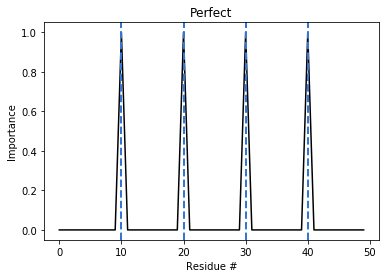

2019-05-07 16:46:11 accuracy_comp-INFO: 
	-------Perfect-------------

	1.00:	(auc)
	1.00:	(ranked_accuray)
	1.00:	(relevant_fraction)
	1.00:	(mse_accuracy)



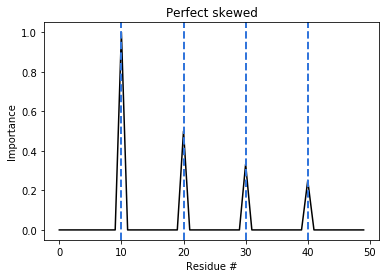

2019-05-07 16:46:11 accuracy_comp-INFO: 
	-------Perfect skewed-------------

	1.00:	(auc)
	0.94:	(ranked_accuray)
	1.00:	(relevant_fraction)
	0.77:	(mse_accuracy)



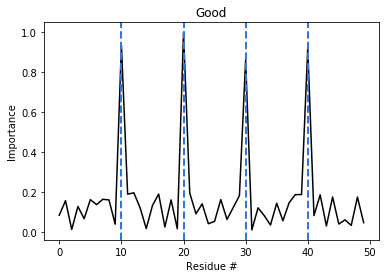

2019-05-07 16:46:11 accuracy_comp-INFO: 
	-------Good-------------

	1.00:	(auc)
	1.00:	(ranked_accuray)
	0.43:	(relevant_fraction)
	0.91:	(mse_accuracy)



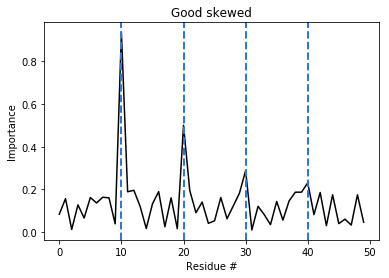

2019-05-07 16:46:11 accuracy_comp-INFO: 
	-------Good skewed-------------

	1.00:	(auc)
	0.94:	(ranked_accuray)
	0.28:	(relevant_fraction)
	0.65:	(mse_accuracy)



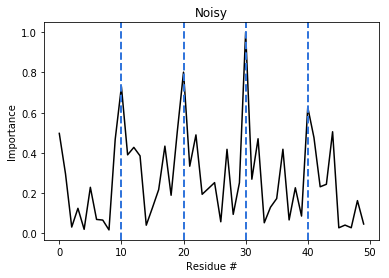

2019-05-07 16:46:11 accuracy_comp-INFO: 
	-------Noisy-------------

	1.00:	(auc)
	0.94:	(ranked_accuray)
	0.23:	(relevant_fraction)
	0.62:	(mse_accuracy)



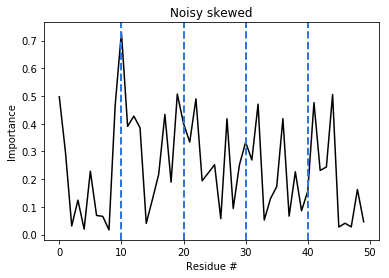

2019-05-07 16:46:11 accuracy_comp-INFO: 
	-------Noisy skewed-------------

	0.71:	(auc)
	0.94:	(ranked_accuray)
	0.13:	(relevant_fraction)
	0.38:	(mse_accuracy)



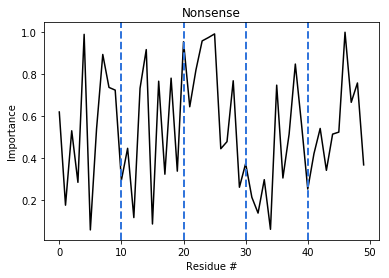

2019-05-07 16:46:11 accuracy_comp-INFO: 
	-------Nonsense-------------

	0.39:	(auc)
	0.54:	(ranked_accuray)
	0.07:	(relevant_fraction)
	0.17:	(mse_accuracy)



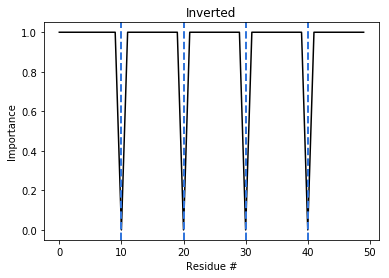

2019-05-07 16:46:11 accuracy_comp-INFO: 
	-------Inverted-------------

	0.00:	(auc)
	0.00:	(ranked_accuray)
	0.00:	(relevant_fraction)
	-0.00:	(mse_accuracy)

2019-05-07 16:46:11 accuracy_comp-DEBUG: Done


In [7]:
profiles = create_profiles()
for p in profiles:
    accuracy = p.compute_accuracy()
    p.plot()
    logger.info("\n\t-------%s-------------\n\n\t%s\n", 
                p.name, 
                "\n\t".join(["{:.2f}:\t({})".format(a, m) for m,a in accuracy])
               )    
logger.debug("Done")

## Get som statistics

Average this over several runs of random values

In [6]:
niterations = 20
results = []
for i in range(niterations):
    profiles = create_profiles()
    for j, p in enumerate(profiles):
        accuracy = p.compute_accuracy()
        if i == 0:
            results.append((p.name, [(m,[a]) for m,a in accuracy]))
        else:
            old_accuracy = results[j][1]
            for k, (m, a) in enumerate(accuracy):
                old_accuracy[k][1].append(a)
        
text = ""
for name, accuracy  in results:
    logger.info("\n\t-------%s-------------\n\n\t%s\n", 
                name, 
                "\n\t".join(["{:.2f} +- {:.2f}:\t({})".format(np.mean(a), np.std(a), m) for m,a in accuracy])
                )    
logger.debug("Done with %s iterations", niterations)

2019-05-07 16:45:56 accuracy_comp-INFO: 
	-------Perfect-------------

	1.00 +- 0.00:	(auc)
	1.00 +- 0.00:	(ranked_accuray)
	1.00 +- 0.00:	(relevant_fraction)
	1.00 +- 0.00:	(mse_accuracy)

2019-05-07 16:45:56 accuracy_comp-INFO: 
	-------Perfect skewed-------------

	1.00 +- 0.00:	(auc)
	0.94 +- 0.00:	(ranked_accuray)
	1.00 +- 0.00:	(relevant_fraction)
	0.77 +- 0.00:	(mse_accuracy)

2019-05-07 16:45:56 accuracy_comp-INFO: 
	-------Good-------------

	1.00 +- 0.00:	(auc)
	1.00 +- 0.00:	(ranked_accuray)
	0.45 +- 0.02:	(relevant_fraction)
	0.92 +- 0.01:	(mse_accuracy)

2019-05-07 16:45:56 accuracy_comp-INFO: 
	-------Good skewed-------------

	1.00 +- 0.00:	(auc)
	0.94 +- 0.00:	(ranked_accuray)
	0.30 +- 0.02:	(relevant_fraction)
	0.66 +- 0.01:	(mse_accuracy)

2019-05-07 16:45:56 accuracy_comp-INFO: 
	-------Noisy-------------

	1.00 +- 0.00:	(auc)
	0.97 +- 0.02:	(ranked_accuray)
	0.20 +- 0.03:	(relevant_fraction)
	0.57 +- 0.07:	(mse_accuracy)

2019-05-07 16:45:56 accuracy_comp-INFO: 
	--